<div style="display:flex; gap:20px;">
  <div style="background-color:'#1E1E1E'; padding:10px;">
    <img src="output/visuals_Re200.gif" width="600">
  </div>
  <div style="background-color:'#1E1E1E'; padding:10px;">
    <img src="output/visuals_Re400.gif" width="600">
  </div>
</div>

### Import core libraries
We start by importing PyTorch and other essential libraries.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from torch.optim.lr_scheduler import ReduceLROnPlateau

# for cleaner look (set your theme to dark mode)
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#1E1E1E'
plt.rcParams['axes.facecolor'] = '#1E1E1E'
plt.rcParams['savefig.facecolor'] = '#1E1E1E'

from tqdm import tqdm
from IPython.display import Image

In [2]:
################# quickfix for Snellius GPU MIG usage
import os 
import subprocess
if "MIG" in subprocess.check_output(["nvidia-smi", "-L"], text=True):
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Check CUDA availability
Here we check if a GPU is available for faster training. GPU usage is highly recommended.

In [3]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device name: {torch.cuda.get_device_name()}")

CUDA available: True
CUDA device name: NVIDIA RTX A1000 6GB Laptop GPU


### Data preparation step
Fuse the raw data files so they can be read by the dataset object.

In [4]:
# this box fuses the loose data files such that they can be read by the dataset object
base_in = '../../data/CFD/grid/loose/'
base_out2 = '../../data/CFD/grid/concat/'
os.makedirs(base_out2, exist_ok=True)
for Re in [100,150,200,250,300,350,400]:
    u = np.load(f"{base_in}u_grid_Re{Re}.npy")
    v = np.load(f"{base_in}v_grid_Re{Re}.npy")
    p = np.load(f"{base_in}p_grid_Re{Re}.npy")
    concat = np.stack([u, v, p], axis=1)
    filename_save = f"{base_out2}uvp_grid_Re{Re}.npy"
    np.save(filename_save, concat)

## Dataset object for standard ARM model

### Model input and output
- **Input**: fluid field information (e.g., velocity and pressure at the current timestep, possibly with coordinates/masks).  
- **Output**: predicted velocity and pressure fields at the **next timestep**.  
This setup makes the model autoregressive: predictions from one step are fed as input to predict the next.

### Define Dataset class
This class handles how fluid data is loaded and accessed. The dataset consists of 7 different trajectories of flow passing a cilindrical obstacle, each with their own Reynolds number. For the training data we use $Re$=[100,200,300,400] and for validation we use zero-shot validation on $Re$=[150,250,350]. The data consists of the $V_x$, $V_y$ and $p$ fields in 2 spatial dimensions and time. At the top of the notebook two example trajectories can be seen. The dataset object also supplies an obstacle mask, the coordinates and the option to flip-augment the data. Only the boolean obstacle mask will be used.

In [5]:
class FlowDataset(Dataset):
    def __init__(self, filenames, flip_augmentation=False, timesample=1):
        self.sequences = []
        self.index_map = []
        self.flip_augmentation = flip_augmentation

        # coordinates
        self.coordsy = np.linspace(-5, 5, 64, endpoint=True)
        self.coordsx = np.linspace(-10, 10, 128, endpoint=True)
        self.coords = np.array(np.meshgrid(self.coordsx, self.coordsy)).T.reshape(128, 64, 2)
        self.coords = torch.tensor(self.coords, dtype=torch.float32).permute(2, 1, 0).cuda()

        # use coordinates to make obstacle mask
        center = torch.tensor([-5.0, 0.0], device=self.coords.device).view(2, 1, 1)
        radius = 0.5
        squared_distance = ((self.coords - center) ** 2).sum(dim=0) 
        self.mask = squared_distance < radius**2  # shape [64, 128]
        self.mask = self.mask.unsqueeze(0).cuda()

        # sample/read the data
        for seq_idx, filename in enumerate(filenames):
            data = np.load(filename)  
            data = data[::timesample] 
            self.sequences.append(data)
            T = data.shape[0]
            self.index_map.extend([(seq_idx, t) for t in range(T - 1)])

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        seq_idx, t = self.index_map[idx]
        seq = self.sequences[seq_idx]
        input = seq[t]    
        target = seq[t + 1] 

        # if flip augmentation is true then flip the data horizontally 50% of the time
        if self.flip_augmentation and np.random.rand() > 0.5:
            input = self.flip(input)
            target = self.flip(target)
        return (
                self.mask, 
                self.coords, 
                torch.tensor(input, dtype=torch.float32), 
                torch.tensor(target, dtype=torch.float32)
                )
        
    def get_trajectory(self, seq_idx):
        # returns full trajectory
        seq = self.sequences[seq_idx]
        return (
            self.mask.unsqueeze(0), 
            self.coords.unsqueeze(0), 
            torch.tensor(seq, dtype=torch.float32)
        )

    def flip(self, x):
        x = np.flip(x, axis=2).copy()
        x[1] *= -1
        return x

datafolder = '../../data/CFD/grid/concat/'
train_files = [
    'uvp_grid_Re100.npy',
    'uvp_grid_Re200.npy',
    'uvp_grid_Re300.npy',
    'uvp_grid_Re400.npy'
]
val_files = [
    'uvp_grid_Re150.npy',
    'uvp_grid_Re250.npy',
    'uvp_grid_Re350.npy'
]
train_files = [datafolder + f for f in train_files]
val_files = [datafolder + f for f in val_files]

dt = 20 # only sample every dt timesteps
batch_size = 64
train_dataset = FlowDataset(train_files, flip_augmentation=False, timesample=dt)
val_dataset = FlowDataset(val_files, flip_augmentation=False, timesample=dt)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Model

### Define Model architecture
Here we build the building blocks of the autoregressive model.

### U-Net architecture (overview)
The model is based on a **U-Net**, which is a type of encoder–decoder neural network with skip connections.
- **Encoder**: progressively downsamples the input, extracting features at multiple scales.
- **Decoder**: upsamples the features back to the original resolution.
- **Skip connections**: link encoder and decoder layers at the same scale, helping the model preserve spatial details.

Below is a generic diagram of U-Net (not exactly your model, but the same idea):



In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropprob=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Dropout2d(p=dropprob)
        )

    def forward(self, x):
        return self.net(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=64,mult=[1, 2, 4, 8]):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, base_channels * mult[0])
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base_channels * mult[0], base_channels * mult[1])
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base_channels * mult[1], base_channels * mult[2])
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base_channels * mult[2], base_channels * mult[3])

        # Decoder
        self.up3 = nn.ConvTranspose2d(base_channels * mult[3], base_channels * mult[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(2 *base_channels * mult[2], base_channels * mult[2])
        self.up2 = nn.ConvTranspose2d(base_channels * mult[2], base_channels * mult[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(2 * base_channels * mult[1], base_channels * mult[1])
        self.up1 = nn.ConvTranspose2d(base_channels * mult[1], base_channels * mult[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(2 * base_channels * mult[0], base_channels * mult[0])
        
        self.out_conv = nn.Conv2d(base_channels * mult[0], out_channels, kernel_size=1)

    def forward(self, x):

        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))

        x4 = self.bottleneck(self.pool3(x3))

        x = self.up3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x)
        x = self.up2(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        return self.out_conv(x)
    
def _amount_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [7]:
base_channels = 64
use_coords = False
use_geometry = True
in_channels = 3
if use_coords:
    in_channels += 2 
if use_geometry:
    in_channels += 1  

epochs = 400
init_lr = 0.001
factor = 0.1
patience = 20
min_lr = 1e-7

train_mode = False # determines whether the model will be trained or loaded from file
save_mode = False # if train_mode is True, then saves the model is save_mode is True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet(in_channels=in_channels, out_channels=3, base_channels=base_channels, mult=[1, 2, 2, 2]).to(device)
print(f"Amount of parameters in model: {_amount_params(model)}, will use {in_channels} input channels")
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=init_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, min_lr=min_lr)

Amount of parameters in model: 2014467, will use 4 input channels


In [8]:
def _input_fuse(mask, coords, input, use_coords, use_geometry):
    # this function fuses the input channels, obstacle mask coordinates and the velocity and pressure data
    if use_coords and use_geometry:
        input = torch.cat([mask, coords, input], dim=1)
    elif use_coords and not use_geometry:
        input = torch.cat([coords, input], dim=1)
    elif not use_coords and use_geometry:
        input = torch.cat([mask, input], dim=1)
    return input

### Training function
Define how the model will be trained (loop, loss, optimizer, etc.). Currently we load the model from memory instead of training.

In [9]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):

    for epoch in range(epochs):
        train_losses = []
        val_loss = []

        model.train()
        train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False) # for cleaner look during training
        for mask, coords, input, target in train_bar:
            mask, coords, input, target = mask.to(device), coords.to(device), input.to(device), target.to(device)
            optimizer.zero_grad()
            input = _input_fuse(mask, coords, input, use_coords, use_geometry) #concat input channels
            output = model(input)
            train_loss = criterion(output, target)
            train_loss.backward()
            optimizer.step()
            train_losses.append(train_loss.item())
            train_bar.set_postfix(loss=f"{train_loss.item():.6f}")

        model.eval()
        val_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}", leave=False)
        with torch.no_grad():
            for mask, coords, input, target in val_bar:
                mask, coords, input, target = mask.to(device), coords.to(device), input.to(device), target.to(device)
                input = _input_fuse(mask, coords, input, use_coords, use_geometry)
                output = model(input)
                loss = criterion(output, target).item()
                val_loss.append(loss)
                val_bar.set_postfix(loss=f"{loss:.6f}")

        if epoch % 10 == 0 or epoch == epochs - 1: # plot every 10 epochs and also at the last epoch
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Train Loss: {np.mean(train_losses):.6f}, Val Loss: {np.mean(val_loss):.6f}, LR: {optimizer.param_groups[0]['lr']:.8f}")
        scheduler.step(np.mean(val_loss)) 


if train_mode == True:
    print("Training mode enabled, starting training...")
    train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)
    if save_mode:
        save_model(model, '../../models/CFD/model1.pth')
else:
    print("Loading model from file...")
    model.load_state_dict(torch.load('../../models/CFD/model1.pth'))

torch.cuda.empty_cache() # clear cache for memory management

Loading model from file...


C:\Users\runeg\AppData\Local\Temp\ipykernel_19676\2781138344.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../models/CFD/model1.p

### Rollout method
A **rollout** means running the trained model forward in time for many steps, using its predictions as inputs for the next steps.  
This is how we evaluate the model’s ability to simulate fluid dynamics beyond a single timestep.

The following block also contains helper functions for creating animations and plotting comparisons...

In [27]:
# helper functions

def rollout(model, mask, coords, init_frame, use_coords, use_geometry, length=100):
    # this function does a rollout of the ARM
    model.eval()
    with torch.no_grad():
        input = _input_fuse(mask, coords, init_frame, use_coords, use_geometry)
        output_sequence = []
        output_sequence.append(init_frame.squeeze(0).cpu())

        for _ in range(length):
            output = model(input)
            output_sequence.append(output.squeeze(0).cpu())
            input = _input_fuse(mask, coords, output, use_coords, use_geometry)

    return torch.stack(output_sequence)

def magnitude(tensor):
    # calculates the radial componentn/magnitude of the 2D velocity field
    return torch.sqrt(tensor[:,0,:,:]**2 + tensor[:,1,:,:]**2)

def animate_rollout(stacked_pred_vel, stacked_true_vel, stacked_pred_p, stacked_true_p, output_path="output/rollout.gif"):
    # this function makes the animation file, given the predicted and true velocity and pressure fields
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    timesteps, x_dim, y_dim = stacked_pred_vel.shape
    if timesteps > stacked_true_vel.shape[0]:
        timesteps = stacked_true_vel.shape[0]
    stacked_pred_vel, stacked_true_vel = stacked_pred_vel.squeeze(1).cpu().numpy(), stacked_true_vel.squeeze(1).cpu().numpy()
    stacked_pred_p, stacked_true_p = stacked_pred_p.squeeze(1).cpu().numpy(), stacked_true_p.squeeze(1).cpu().numpy()
    vmax_vel = min(np.max(stacked_pred_vel), np.max(stacked_true_vel))
    vmax_p = min(np.max(stacked_pred_p), np.max(stacked_true_p))
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))
    titles = ["Pred", "True", "Diff"]
    imgs = []

    for i in range(2):
        row_imgs = []
        for j in range(3):
            ax = axes[i, j]
            img = ax.imshow(np.zeros((x_dim, y_dim)), cmap='viridis', vmin=0, vmax=vmax_vel if i == 0 else vmax_p)
            ax.set_title(titles[j])
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)
            row_imgs.append(img)
        imgs.append(row_imgs)

    axes[0,0].set_ylabel(r'$\sqrt{v_x^2 + v_y^2}$')
    axes[1,0].set_ylabel(r'$p$')
    imgs[0][2].set_cmap('magma')
    imgs[1][2].set_cmap('magma')
    
    def init():
        imgs[0][0].set_data(stacked_pred_vel[0])
        imgs[0][1].set_data(stacked_true_vel[0])
        imgs[1][0].set_data(stacked_pred_p[0])
        imgs[1][1].set_data(stacked_true_p[0])
        return imgs

    def update(frame):

        imgs[0][0].set_data(stacked_pred_vel[frame])
        imgs[0][1].set_data(stacked_true_vel[frame])
        imgs[1][0].set_data(stacked_pred_p[frame])
        imgs[1][1].set_data(stacked_true_p[frame])
        imgs[0][2].set_data(np.abs(stacked_true_vel[frame] - stacked_pred_vel[frame]))
        imgs[1][2].set_data(np.abs(stacked_true_p[frame] - stacked_pred_p[frame]))

        fig.suptitle(f"timestep {frame + 1}\n"
                     #f"vmin: {vmin_frame:.4f}, vmax: {vmax_frame:.4f}")
                        #f"vmax: {vmax_frame:.3f}"
                        )
        return imgs

    ani = animation.FuncAnimation(fig, update, frames=timesteps, init_func=init, blit=False, interval=150)
    ani.save(output_path, writer="ffmpeg")
    plt.close()

def _generate_sequence(model, val_dataset, starting_timestep, length, trajectory_select=1):
    # this function manages the rollout, magnitude calculation and gets the data ready for plotting functionality or animation functionality
    model.eval()
    with torch.no_grad():
        mask, coords, val_traj = val_dataset.get_trajectory(trajectory_select)
        mask, coords, val_traj = mask.to(device), coords.to(device), val_traj.to(device)
        val_traj = val_traj[starting_timestep:]

        anim_data = rollout(model, mask, coords, val_traj[0].unsqueeze(0), use_coords, use_geometry, length=41) 
        velocity = magnitude(anim_data).cpu()
        velocity_test = magnitude(val_traj).cpu()
        pressure = anim_data[:,2,:,:].cpu()
        pressure_test = val_traj[:,2,:,:].cpu()
    return velocity, velocity_test, pressure, pressure_test

def plot_comparison(velocity, velocity_test, pressure, pressure_test):
    # this function plots the comparison between predicted and true fields at some timesteps
    fig, ax = plt.subplots(6, 6, figsize=(10, 7))
    timesteps = [0, 1, 5, 10,20,30]
    for i, t in enumerate(timesteps):
        # turn axis off
        for j in range(6):
            # only remove axis ticks
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            for spine in ax[i, j].spines.values():
                spine.set_visible(False)
        # plot the velocity magnitude and pressure at each time step
        ax[i, 0].imshow(velocity[t].numpy(), cmap='viridis')
        ax[i, 2].imshow(pressure[t].numpy(), cmap='viridis')
        ax[i, 1].imshow(velocity_test[t].numpy(), cmap='viridis')
        ax[i, 3].imshow(pressure_test[t].numpy(), cmap='viridis')
    ax[0, 0].set_title('Predicted Velocity Magnitude')
    ax[0, 2].set_title('Predicted Pressure')
    ax[0, 1].set_title('True Velocity Magnitude')
    ax[0, 3].set_title('True Pressure')
    ax[0, 0].set_ylabel('t={t}'.format(t=timesteps[0]))
    ax[1, 0].set_ylabel('t={t}'.format(t=timesteps[1]))
    ax[2, 0].set_ylabel('t={t}'.format(t=timesteps[2]))
    ax[3, 0].set_ylabel('t={t}'.format(t=timesteps[3]))
    plt.tight_layout()
    plt.show()


### Set starting timestep
Choose the timestep where the prediction sequence begins and call the animation function of the model.

MovieWriter ffmpeg unavailable; using Pillow instead.


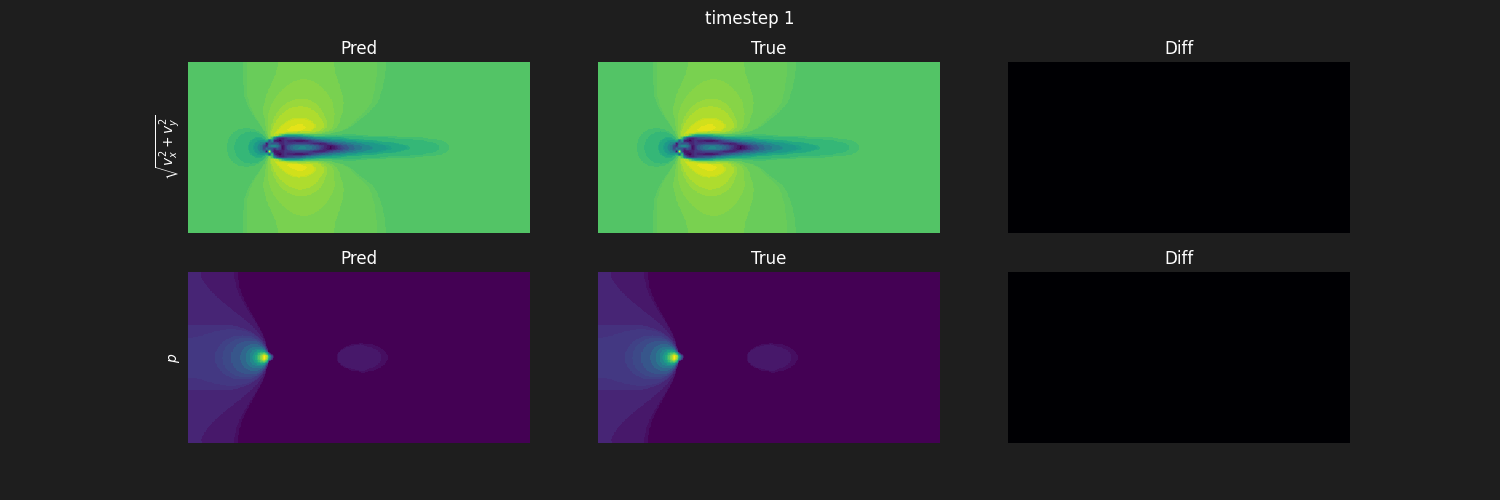

In [11]:
starting_timestep = 6
velocity, velocity_true, pressure, pressure_true = _generate_sequence(model, val_dataset, starting_timestep, length=41, trajectory_select=1)
animate_rollout(velocity, velocity_true, pressure, pressure_true, output_path="output/rollout_model1.gif")
Image(filename="output/rollout_model1.gif")

### Plot comparison
Here we visualize predicted vs true velocity and pressure fields side-by-side. Although the model predicts the next timestep quite well, the predictions deviate from the true trajectories in the long run...

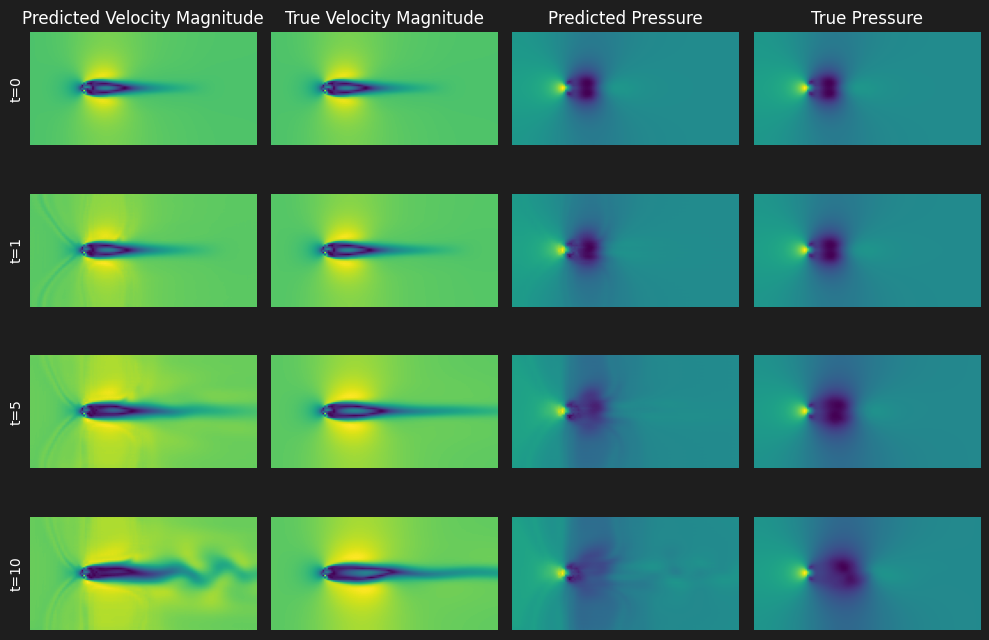

In [12]:
plot_comparison(velocity, velocity_true, pressure, pressure_true)

## Push-forward training


Push-forward training means that during training, the model is rolled out over several timesteps by feeding its **own predictions** back as input.  
- At step 1: use ground truth input → predict next step.  
- At step 2: feed the prediction from step 1 → predict next step.  
- Continue for multiple steps.  

This helps the model learn to stay stable during long rollouts, where small errors can otherwise accumulate quickly.

In [13]:
# since we are now planning on doing the pushforward trick, the
# data pipeline needs to be changed such that it supplements multiple timesteps as target from which a single target can be selected

class FlowDatasetPushForward(Dataset):
    def __init__(self, filenames, flip_augmentation=False, timesample=1, forward_steps=5):
        self.sequences = []
        self.index_map = []
        self.flip_augmentation = flip_augmentation
        self.forward_steps = forward_steps # this value determines how many forward timesteps are returned by the dataloader

        # coordinates
        self.coordsy = np.linspace(-5, 5, 64, endpoint=True) # coords are hardcoded
        self.coordsx = np.linspace(-10, 10, 128, endpoint=True)
        self.coords = np.array(np.meshgrid(self.coordsx, self.coordsy)).T.reshape(128, 64, 2)
        self.coords = torch.tensor(self.coords, dtype=torch.float32).permute(2, 1, 0).cuda()

        # obstacle mask 
        center = torch.tensor([-5.0, 0.0], device=self.coords.device).view(2, 1, 1)  
        radius = 0.5
        squared_distance = ((self.coords - center) ** 2).sum(dim=0)
        self.mask = (squared_distance < radius ** 2).unsqueeze(0).cuda()

        # Load/sample data
        for seq_idx, filename in enumerate(filenames):
            data = np.load(filename)   # [T, C, H, W]
            data = data[::timesample]
            self.sequences.append(data)
            T = data.shape[0]
            # ensure enough room for multiple forward solves/rollout steps
            self.index_map.extend([(seq_idx, t) for t in range(T - forward_steps)])

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        seq_idx, t = self.index_map[idx]
        seq = self.sequences[seq_idx]

        input = seq[t]                               # [C, H, W]
        targets = seq[t+1:t+self.forward_steps+1]     # [forward_steps, C, H, W]

        if self.flip_augmentation and np.random.rand() > 0.5: # flip-augment if wanted
            input = self.flip(input)
            targets = [self.flip(target) for target in targets]

        return (
            self.mask, 
            self.coords, 
            torch.tensor(input, dtype=torch.float32), 
            torch.tensor(targets, dtype=torch.float32)
        )

    def get_trajectory(self, seq_idx):
        # returns full trajectory 
        seq = self.sequences[seq_idx]
        return (
            self.mask.unsqueeze(0), 
            self.coords.unsqueeze(0), 
            torch.tensor(seq, dtype=torch.float32)
        )

    def flip(self, x):
        x = np.flip(x, axis=1).copy()
        x[2] *= -1
        return x

    
datafolder = '../../data/CFD/grid/concat/'
train_files = [
    'uvp_grid_Re100.npy',
    'uvp_grid_Re200.npy',
    'uvp_grid_Re300.npy',
    'uvp_grid_Re400.npy'
]
val_files = [
    'uvp_grid_Re150.npy',
    'uvp_grid_Re250.npy',
    'uvp_grid_Re350.npy'
]
train_files = [datafolder + f for f in train_files]
val_files = [datafolder + f for f in val_files]

dt = 20 # only sample from data every dt timesteps
batch_size = 64
max_forward_steps = 4 # maximum number of push-forward steps
train_dataset = FlowDatasetPushForward(train_files, flip_augmentation=False, timesample=dt, forward_steps=max_forward_steps)
val_dataset = FlowDatasetPushForward(val_files, flip_augmentation=False, timesample=dt, forward_steps=max_forward_steps)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model3 = SimpleUNet(in_channels=in_channels, out_channels=3, base_channels=base_channels).to(device)
optimizer3 = Adam(model3.parameters(), lr=init_lr)
scheduler3 = ReduceLROnPlateau(optimizer3, mode='min', factor=factor, patience=patience, min_lr=min_lr)
criterion = nn.MSELoss()

  Mask shape: torch.Size([64, 1, 64, 128])
  Inputs shape: torch.Size([64, 3, 64, 128])
  Targets shape: torch.Size([64, 4, 3, 64, 128])


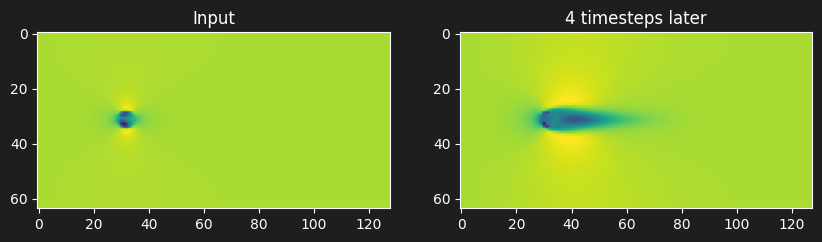

In [14]:
# just to get a feeling for the data

for i, (mask, coords, inputs, targets) in enumerate(val_loader):
    print(f"  Mask shape: {mask.shape}")
    print(f"  Inputs shape: {inputs.shape}")
    print(f"  Targets shape: {targets.shape}")
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(inputs[0,0].cpu().numpy(), cmap='viridis')
    ax[0].set_title("Input")
    ax[1].imshow(targets[0, max_forward_steps-1,0].cpu().numpy(), cmap='viridis')
    ax[1].set_title(f"{max_forward_steps} timesteps later")
    plt.show()
    break

Your job is to implement the push-forward training function. Use the _pushforward_schedule() function to sample the amount of forward rollout steps that your model needs to do during each training step. 
* Think about whether your model should backpropagate loss of all the rollout steps or only a specific portion
* Think about a suitable learning strategy that balances rollout-stability and single step accuracy (Your model might forget to accurately predict next-timesteps if only trained on the far-future).
* You are allowed to use the obstacle mask, but not the coordinates.

In [ ]:
import numpy as np
from torch.cuda.amp import autocast, GradScaler

def _pushforward_schedule(epoch, max_forward_steps=3, epochs=200):
    """
    Return how many rollout steps to use this batch.
    - Most of the time: 1 step (no push-forward).
    - Occasionally: 2 or 3 steps (capped at max_forward_steps).
    The chance of using PF grows slightly over training but stays low.
    """
    base_p = 0.05
    grow_p = 0.20 * (epoch / max(1, epochs))
    p_pf = min(base_p + grow_p, 0.25)

    if np.random.rand() > p_pf:
        return 1  

    max_forward_steps = min(max_forward_steps, 3)
    return np.random.randint(2, max_forward_steps + 1)


def train_PF(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs,
             max_forward_steps, use_amp=True, device=None):
    if device is None:
        device = next(model.parameters()).device
    scaler = GradScaler(enabled=use_amp)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_pf3_logs = []  
        train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False)

        for mask, _coords, inputs, targets in train_bar:
            mask   = mask.to(device, non_blocking=True)
            inputs = inputs.to(device, non_blocking=True)       
            targets= targets.to(device, non_blocking=True)       

            steps = _pushforward_schedule(epoch, max_forward_steps=max_forward_steps, epochs=epochs)

            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=use_amp):
                x = torch.cat([mask, inputs], dim=1)               
                pred1 = model(x)                                   
                loss = criterion(pred1, targets[:, 0])

                if steps >= 2:
                    x = torch.cat([mask, pred1.detach()], dim=1)
                    pred2 = model(x)
                    loss = loss + 0.3 * criterion(pred2, targets[:, 1])

                pf3_loss = None
                if steps >= 3:
                    with torch.no_grad():
                        x = torch.cat([mask, pred2.detach()], dim=1) if steps >= 2 else torch.cat([mask, pred1.detach()], dim=1)
                        pred3 = model(x)
                        pf3_loss = criterion(pred3, targets[:, 2]).item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.detach().item())
            if pf3_loss is not None:
                train_pf3_logs.append(pf3_loss)

            if pf3_loss is not None:
                train_bar.set_postfix(steps=steps, loss=f"{train_losses[-1]:.6f}", pf3=f"{pf3_loss:.4f}")
            else:
                train_bar.set_postfix(steps=steps, loss=f"{train_losses[-1]:.6f}")

        model.eval()
        val_losses = []
        val_pf2_logs = []
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}", leave=False)
            for mask, _coords, inputs, targets in val_bar:
                mask   = mask.to(device, non_blocking=True)
                inputs = inputs.to(device, non_blocking=True)
                targets= targets.to(device, non_blocking=True)

                x = torch.cat([mask, inputs], dim=1)
                pred1 = model(x)
                vloss = criterion(pred1, targets[:, 0]).item()

                x = torch.cat([mask, pred1], dim=1)
                pred2 = model(x)
                vpf2 = criterion(pred2, targets[:, 1]).item()

                val_losses.append(vloss)
                val_pf2_logs.append(vpf2)
                val_bar.set_postfix(val=f"{vloss:.6f}", pf2=f"{vpf2:.4f}")

        mean_train = float(np.mean(train_losses)) if len(train_losses) else 0.0
        mean_val   = float(np.mean(val_losses)) if len(val_losses) else 0.0


        msg = f"Epoch {epoch+1}/{epochs} | Train {mean_train:.6f} | Val {mean_val:.6f}"

        print(msg)

        scheduler.step(mean_val)



In [32]:


train_mode = True
save_mode = True

if train_mode == True:
    print("Training mode enabled, starting training...")
    train_PF(model3, train_loader, val_loader, criterion, optimizer3, scheduler3, 200,max_forward_steps=4)
    if save_mode:
        save_model(model3, '../../models/CFD/model3.pth')
else:
    print("Loading model from file...")
    model3.load_state_dict(torch.load('../../models/CFD/model3.pth'))

C:\Users\runeg\AppData\Local\Temp\ipykernel_19676\3596650833.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


Training mode enabled, starting training...


Training Epoch 1/200:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\runeg\AppData\Local\Temp\ipykernel_19676\3596650833.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 1/200 | Train 0.003458 | Val 0.000460


Epoch 2/200 | Train 0.003169 | Val 0.000456


Epoch 3/200 | Train 0.003513 | Val 0.000454


Epoch 4/200 | Train 0.003812 | Val 0.000462


Epoch 5/200 | Train 0.003715 | Val 0.000452


Epoch 6/200 | Train 0.003602 | Val 0.000453


Epoch 7/200 | Train 0.003891 | Val 0.000448


KeyboardInterrupt: 

Let us now look at the animation and plots from the push-forward trained model. How does the new model compare to the old model?

MovieWriter ffmpeg unavailable; using Pillow instead.


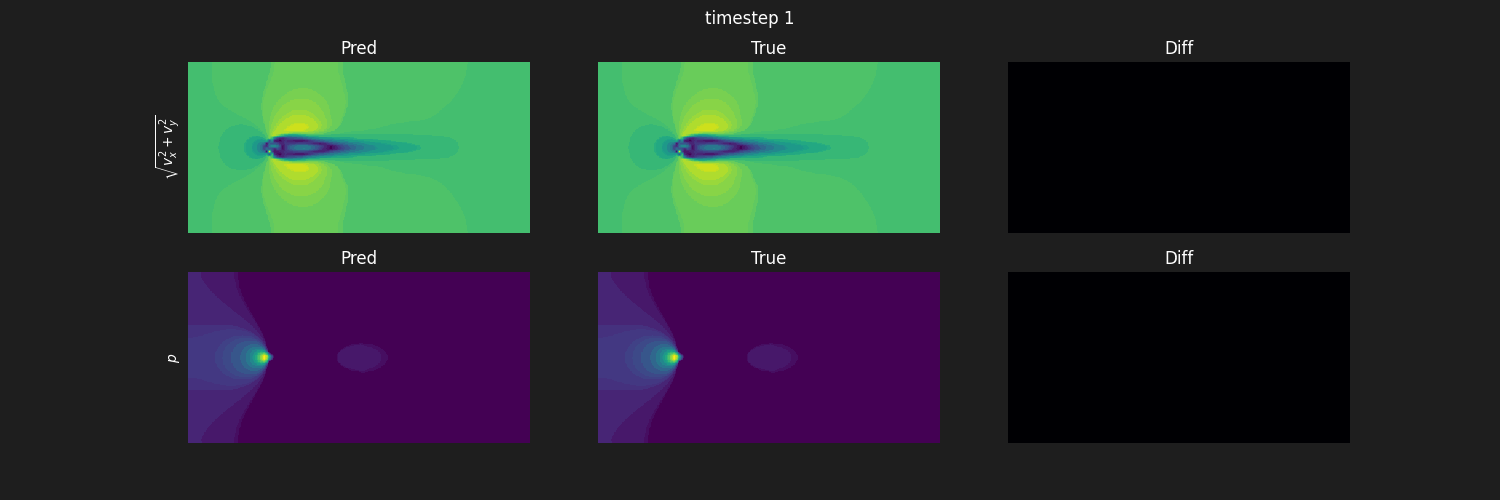

In [21]:
velocity, velocity_true, pressure, pressure_true = _generate_sequence(model3, val_dataset, starting_timestep, length=41, trajectory_select=1)
animate_rollout(velocity, velocity_true, pressure, pressure_true, output_path="output/rollout_model3.gif")
Image(filename="output/rollout_model3.gif")

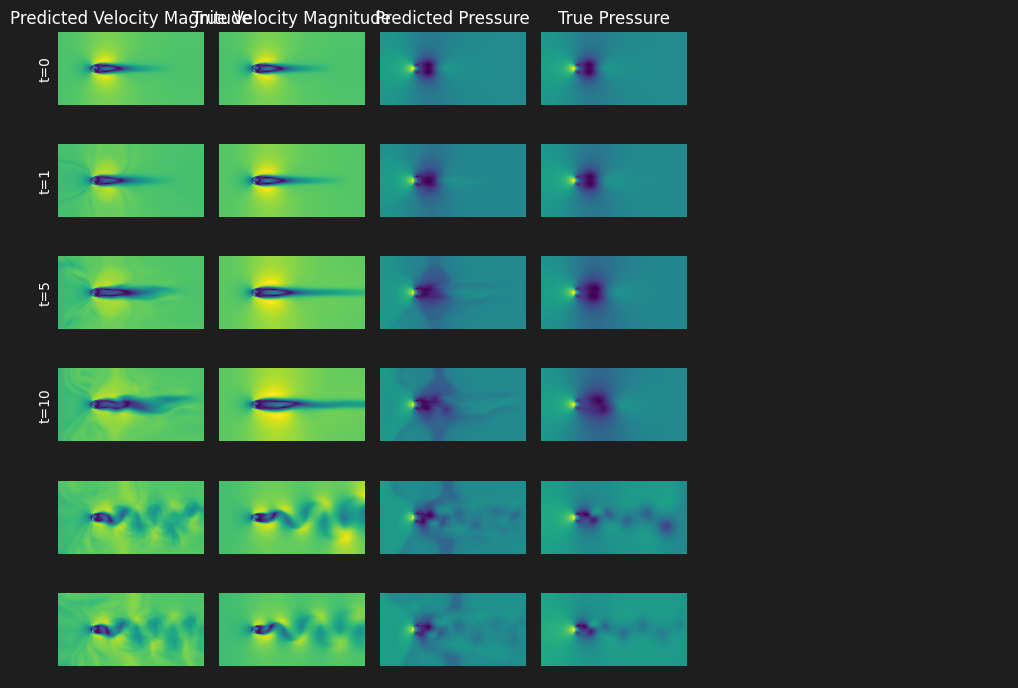

In [28]:
plot_comparison(velocity, velocity_true, pressure, pressure_true)